### Transport algorithm to calculate upwelled water (and tracer) 

Define shelf boundary and calculate volume of water transported onto the shelf through cells with $C_i \ge C_s$

In [351]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [352]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [353]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def find_NoCShelf_ind(hfacNoC, nz=103):
    '''Find x,y,z indices of the no-canyon shelf
       hfacNoc is HFacC (or S or W) from the no canyon bathymetry (nz,ny,nx)
       RETURNS:
       Array of z-indices of the shelf bottom, size (ny,nx)
       '''
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*nz - BottomInd) # Get index of unreversed z axis
    return (BottomInd.astype(int))

In [354]:
sns.set_context('notebook')
sns.set_style('white')

### Barkley linear stratification

In [355]:
Grid = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/03_Bar03_Path/gridGlob.nc' 
with Dataset(Grid, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    Y = nbl.variables['Y'][:]
    X = nbl.variables['X'][:]
    hFac = nbl.variables['HFacC'][:]
    Depth = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFac, 0)
    maskC = np.ma.getmask(hfac)
    rA = nbl.variables['rA'][:]
    dxg = nbl.variables['dxG'][:]
    drf = nbl.variables['drF'][:]
    Zf = nbl.variables['RF'][:]
GridNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/04_Bar03_No_Cny_Path/gridGlob.nc' 
with Dataset(GridNoC, 'r') as nbl:
    Znoc = nbl.variables['RC'][:]
    Ynoc = nbl.variables['Y'][:]
    Xnoc = nbl.variables['X'][:]
    hFacnoc = nbl.variables['HFacC'][:]
    Depthnoc = nbl.variables['Depth'][:]
    hfacnoc = np.ma.masked_values(hFacnoc, 0)
    maskCnoc = np.ma.getmask(hfacnoc)
    rAv = nbl.variables['rA'][:]

State = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/03_Bar03_Path/stateGlob.nc' 
StateNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/04_Bar03_No_Cny_Path/stateGlob.nc' 
st = xr.open_dataset(State)
stNoC = xr.open_dataset(StateNoC)

Ptracer = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/03_Bar03_Path/ptracersGlob.nc' 
ptr = xr.open_dataset(Ptracer)

PtracerNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/04_Bar03_No_Cny_Path/ptracersGlob.nc' 
ptrNoC = xr.open_dataset(PtracerNoC)


In [356]:
z_slice = slice(0,80)
z_slice_zoom = slice(0,40)
y_ind = 129 # sb index
z_ind = 39 # sb index

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


4.95804398148141
1.763599537036754


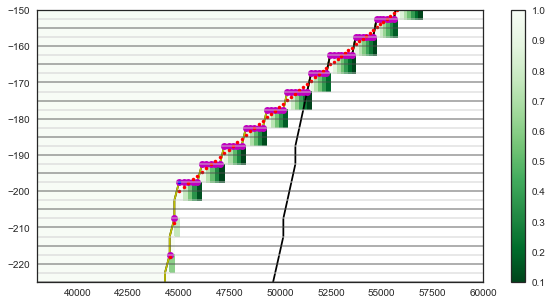

In [357]:
fig, ax = plt.subplots(1,1,figsize=(10,5), sharey=True)
pc = ax.pcolormesh(Y,Z,hfac[:,:,100], cmap='Greens_r')
plt.colorbar(pc)

ax.contour(Y,Z,maskC[:,:,100],levels=[0],colors=['k'])
ax.contour(Y,Z,maskCnoc[:,:,100],levels=[0],colors=['y'])
ax.contour(Y,Z,maskC[:,:,180],levels=[0],colors=['k'])

sh_bot = find_NoCShelf_ind(hfacnoc)

ax.plot(Y,Z[sh_bot[:,100]], 'mo')

ax.plot(Y,-Depth[:,100],'r.')
ax.set_ylim(-225,-150)
ax.set_xlim(38000,60000)
ax.plot(Y[y_ind],Z[39],'.b')
for dep in Z:
    ax.axhline(dep, color='0.8', alpha=0.5)
for dep in Zf:
    ax.axhline(dep, color='0.3', alpha=0.5)

#cell thickness at tracer point
th_sh = hfac[39,129,100]*drf[39]
print(th_sh)
th_other = hfac[39,132,100]*drf[39]
print(th_other)



### Define subdomain width

W = 11.4 km
Wiso = 4.5 km
W ups = 22.0 km
W dns = 22.3 km


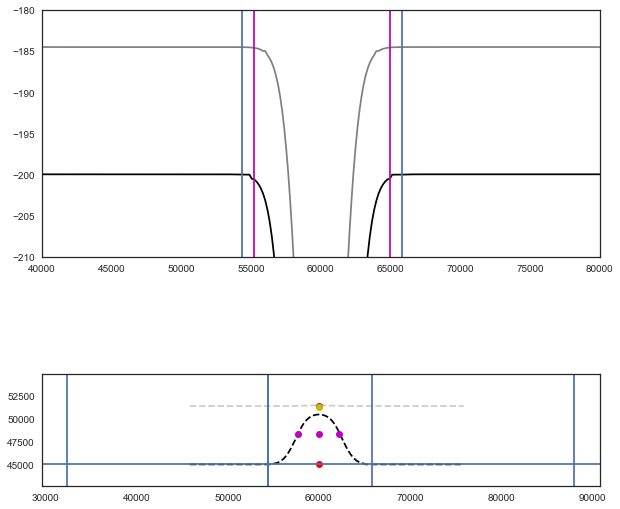

In [358]:
W1 = 140
W2 = 220
Wiso1 = 145
Wiso2 = 215

W_ini = W1-79
W_end = W2+79

fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(X[50:-300],-Depth[y_ind,50:-300],'k')
ax[0].plot(X[50:-300],-Depth[y_ind+15,50:-300],'0.5')

ax[0].axvline(X[W1])
ax[0].axvline(X[W2])
ax[0].axvline(X[W_ini])
ax[0].axvline(X[W_end])
ax[0].axvline(X[Wiso1],color='m')
ax[0].axvline(X[Wiso2],color='m')

ax[1].contour(X[100:-350],Y[y_ind-10:-180],-Depth[y_ind-10:-180,100:-350],levels=[-200],colors=['k'])
ax[1].contour(X[100:-350],Y[y_ind-10:-180],-Depth[y_ind-10:-180,100:-350],levels=[-170],colors=['0.8'])

ax[1].plot(X[180],Y[y_ind],'ro')
ax[1].plot(X[180],Y[y_ind]+6400,'ro')
ax[1].plot(X[180],Y[y_ind+30],'yo')
ax[1].plot(X[180],Y[y_ind+15],'mo')
ax[1].plot(X[197],Y[y_ind+15],'mo')
ax[1].plot(X[161],Y[y_ind+15],'mo')

ax[1].axvline(X[W1])
ax[1].axvline(X[W1])
ax[1].axvline(X[W2])
ax[1].set_aspect(1)
ax[1].axvline(X[W_ini])
ax[1].axvline(X[W_end])
ax[1].axhline(Y[y_ind])

ax[0].set_ylim(-210,-180)
ax[0].set_xlim(40000,80000)

print('W = %1.1f km' %((X[W2]-X[W1])/1000))
print('Wiso = %1.1f km' %((X[197]-X[161])/1000))

print('W ups = %1.1f km' %((X[W1]-X[W_ini])/1000))
print('W dns = %1.1f km' %((X[W_end]-X[W2])/1000))


In [359]:
x_slice = slice(W_ini,W_end)
x_slice_vert = slice(W1,W2)
y_slice_vert = slice(y_ind,y_ind+100)

Tracer 01 concentration at day 6.0 at shelf break cross-section and shelf-break depth horizontal section.
 Masked values have C<C_s=9.0 uM


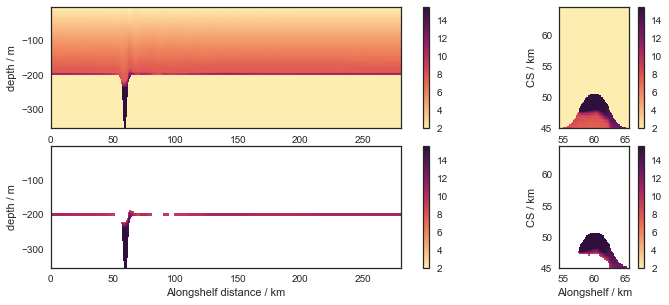

In [360]:
tt = 12
bgcolor = '#8b7765'

f = plt.figure(figsize = (11,4.8))
gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace = 0.0)
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.1,height_ratios=[1,1])
gs2 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1],hspace=0.15,wspace=0.1,height_ratios=[1,1])

ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

#ax1.set_facecolor(bgcolor)
#ax2.set_facecolor(bgcolor)
#ax3.set_facecolor(bgcolor)
#ax0.set_facecolor(bgcolor)

Cs = ptr.Tr01[0,z_ind,50,180]
Cmax = ptr.Tr01[0,62,50,180]
Cmin = ptr.Tr01[0,0,50,180]

Tr_masked = ptr.Tr01[tt,:62,y_ind,:]#np.ma.masked_array(ptr.Tr01[tt,:62,y_ind,:],mask=maskC[:62, y_ind,:])

pc0 = ax0.pcolormesh(X/1000,Z[:62],Tr_masked, cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
pc1 = ax1.pcolormesh(X/1000,Z[:62],np.ma.masked_less(Tr_masked, Cs), 
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc0, ax=ax0)
plt.colorbar(pc1, ax=ax1)
ax0.set_ylabel('depth / m')
ax1.set_ylabel('depth / m')
ax1.set_xlabel('Alongshelf distance / km')

Tr_masked_v = ptr.Tr01[tt,z_ind+1,y_slice_vert,x_slice_vert]#np.ma.masked_array(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert],mask=maskC[z_ind,y_slice_vert, x_slice_vert])

pc2 = ax2.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
                     Tr_masked_v,
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc2, ax=ax2)
pc3 = ax3.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
                     np.ma.masked_less(Tr_masked_v, Cs), 
                     cmap=cmo.cm.matter, vmax=Cmax, vmin = Cmin)
plt.colorbar(pc3, ax=ax3)

mask_cs = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,:62,y_ind,:], Cs))
mask_vert = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,z_ind+1,y_slice_vert,x_slice_vert], Cs))

ax3.set_xlabel('Alongshelf / km')
ax2.set_ylabel('CS / km')
ax3.set_ylabel('CS / km')

ax2.set_aspect(1)
ax3.set_aspect(1)

print('Tracer 01 concentration at day %1.1f at shelf break cross-section and shelf-break depth horizontal section.\n Masked values have C<C_s=%1.1f uM' %(tt/2, Cs))

V, W at day 8.0 at shelf break cross-section and shelf-break depth horizontal section. 
 Masked values have C<C_s=9.0 uM


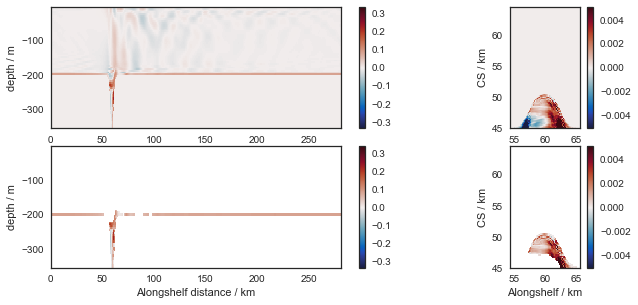

In [361]:
tt = 16
f = plt.figure(figsize = (10,4.8))
gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0.2)
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15,wspace=0.15,height_ratios=[1,1])
gs2 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1],hspace=0.15,wspace=0.15,height_ratios=[1,1])

ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

Vmax = np.max(st.V[10,:,:,:])
Vmin = -Vmax #np.min(st.V[10,:,:,:])
Wmax = np.max(st.W[10,62,:,:])
Wmin = -Wmax#np.min(st.W[10,:,:,:])

V = st.V.isel(T = tt,Z=slice(0,62))
V = np.add(V[..., :-1, :], V[..., 1:, :]) / 2
V_masked = V[:,y_ind,:]#np.ma.masked_array(V[:,y_ind,:],mask=maskC[:62, y_ind,:])

pc0 = ax0.pcolormesh(X/1000,Z[:62],V_masked, cmap=cmo.cm.balance, vmax=Vmax, vmin = Vmin)
pc1 = ax1.pcolormesh(X/1000,Z[:62],np.ma.masked_array(V_masked, mask = mask_cs),
               cmap=cmo.cm.balance, vmax=Vmax, vmin = Vmin)
plt.colorbar(pc0, ax=ax0)
plt.colorbar(pc1, ax=ax1)
ax0.set_ylabel('depth / m')
ax1.set_ylabel('depth / m')
ax1.set_xlabel('Alongshelf distance / km')

W_masked = st.W[tt,z_ind+1,y_slice_vert,x_slice_vert]#np.ma.masked_array(st.W[tt,z_ind,y_slice_vert,x_slice_vert],mask=maskC[z_ind, y_slice_vert, x_slice_vert])

pc2 = ax2.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,W_masked,
               cmap=cmo.cm.balance, vmax = Wmax, vmin = Wmin)
pc3 = ax3.pcolormesh(X[x_slice_vert]/1000,Y[y_slice_vert]/1000,
               np.ma.masked_array(W_masked, mask=mask_vert), 
               cmap=cmo.cm.balance, vmax = Wmax, vmin = Wmin)
plt.colorbar(pc2, ax=ax2)
plt.colorbar(pc3, ax=ax3)
ax3.set_xlabel('Alongshelf / km')
ax2.set_ylabel('CS / km')
ax3.set_ylabel('CS / km')

ax2.set_aspect(1)
ax3.set_aspect(1)

print('V, W at day %1.1f at shelf break cross-section and shelf-break depth horizontal section. \n Masked values have C<C_s=%1.1f uM' %(tt/2, Cs))

**Algorithm**

In [362]:
y_ind = y_ind
z_ind = 39
x_st = 180
y_st = 50

x_slice = slice(W_ini,W_end)
x_slice_vert = slice(W_ini,W_end)
y_slice_vert = slice(y_ind,y_ind+100)

Cs = ptr.Tr01[0,z_ind,y_st,x_st]
tt = slice(0,19)

# Mask using Cs criterion 
mask_exp = mpt.maskExpand(maskC[:z_ind+1,:,x_slice],ptr.Tr01[tt,:z_ind+1,:,x_slice])
Tr_masked = ptr.Tr01[tt,:z_ind+1,y_ind,x_slice]
Tr_masked_v = ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert]

# Get tracer mask
mask_cs = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,:z_ind+1,y_ind,x_slice], Cs))
mask_vert = np.ma.getmask(np.ma.masked_less(ptr.Tr01[tt,z_ind,y_slice_vert,x_slice_vert], Cs))

# Get V and unstagger
V = st.V.isel(T = tt, Z=slice(0,z_ind+1))
V = np.add(V[..., :-1, :], V[..., 1:, :]) / 2
V_masked = V[...,y_ind,x_slice]

# Apply tracer mask to unstaggered V
V_upw = np.ma.masked_array(V_masked, mask = mask_cs)

# Calculate transport
drf_exp = np.expand_dims(np.expand_dims(drf[:z_ind+1],1),0)
drf_exp = drf_exp + np.zeros(mask_cs.shape)

dxg_exp = np.expand_dims(np.expand_dims(dxg[y_ind,x_slice],0),0)
dxg_exp = dxg_exp + np.zeros(mask_cs.shape)

hfac_exp = mpt.maskExpand(hfac[:z_ind+1,y_ind,x_slice],mask_cs)
wat = drf_exp*dxg_exp*hfac_exp*V_upw

# Apply land mask to W 
W_masked = st.W[tt,z_ind,y_slice_vert,x_slice_vert]

# Apply tracer mask to land-masked W
rA_exp = np.expand_dims(rA[y_slice_vert,x_slice_vert], 0)
rA_exp = rA_exp + np.zeros(np.shape(W_masked))
W_upw = np.ma.masked_array(W_masked*rA_exp, mask=mask_vert)

In [363]:
Cs = ptrNoC.Tr01[0,z_ind,y_st,x_st]
tt = slice(0,19)

# Mask using Cs criterion 
mask_exp = mpt.maskExpand(maskCnoc[:z_ind+1,:,x_slice],ptrNoC.Tr01[tt,:z_ind+1,:,x_slice])
Tr_masked = ptrNoC.Tr01[tt,:z_ind+1,y_ind,x_slice]

# Get tracer mask
mask_cs = np.ma.getmask(np.ma.masked_less(ptrNoC.Tr01[tt,:z_ind+1,y_ind,x_slice], Cs))

# Get V and unstagger
V = stNoC.V.isel(T = tt, Z=slice(0,z_ind+1))
V = np.add(V[..., :-1, :], V[..., 1:, :]) / 2
V_masked = V[...,y_ind,x_slice]

# Apply tracer mask to unstaggered V
V_upw = np.ma.masked_array(V_masked, mask = mask_cs)

# Calculate transport
drf_exp = np.expand_dims(np.expand_dims(drf[:z_ind+1],1),0)
drf_exp = drf_exp + np.zeros(mask_cs.shape)

dxg_exp = np.expand_dims(np.expand_dims(dxg[y_ind,x_slice],0),0)
dxg_exp = dxg_exp + np.zeros(mask_cs.shape)

hfac_exp = mpt.maskExpand(hfacnoc[:z_ind+1,y_ind,x_slice],mask_cs)
watNoC = drf_exp*dxg_exp*hfac_exp*V_upw

Mean upwelling flux days 4-9 is 5.95e+04 m^3s^{-1} \pm 4.62e+03
Mean upwelling flux (anomaly) days 4-9 is 3.83e+04 m^3s^{-1} 


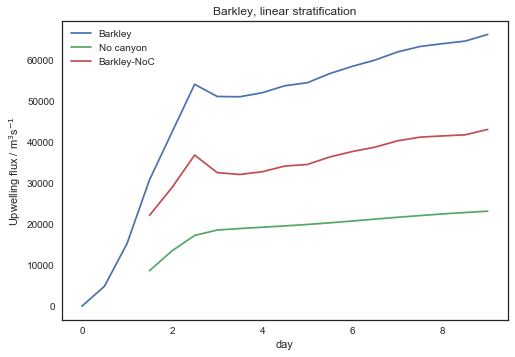

In [364]:
phi = np.sum(np.sum(W_upw,axis=1),axis=1)+np.sum(np.sum(wat,axis=1),axis=1)
phiNoC = np.sum(np.sum(watNoC,axis=1),axis=1)

plt.plot(np.arange(np.shape(phi)[0])/2,phi, label='Barkley')
plt.plot(np.arange(np.shape(phi)[0])/2,phiNoC, label='No canyon')
plt.plot(np.arange(np.shape(phi)[0])/2,phi-phiNoC, label='Barkley-NoC')

plt.legend()
plt.xlabel('day')
plt.ylabel('Upwelling flux / m$^3$s$^{-1}$')
plt.title('Barkley, linear stratification')
print('Mean upwelling flux days 4-9 is %1.2e m^3s^{-1} \pm %1.2e' %(np.mean(phi[8:]),np.std(phi[8:])))
print('Mean upwelling flux (anomaly) days 4-9 is %1.2e m^3s^{-1} ' %(np.mean(phi[8:])-np.mean(phiNoC[8:])))


### Scaling estimate

In [365]:
def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [366]:
g = 9.81 # accel. gravity
Hs = 200 # Shelf break depth
s = 0.00454 # shelf slope 
N = 4.69E-3#5.5E-3
f = 1.08E-4
U = 0.495
Wiso = 4500 
L = 6400

#H&A 2013
slope = 0.91 
param = 1.21
intercept = 0.07

Se = SE(s, N, f, F(Ro(U,f,Wiso)), Ro(U,f,L))
HA2013=((slope*(F(Ro(U,f,Wiso))**(3/2))*(Ro(U,f,L)**(1/2))*((1-param*Se)**3))+intercept)*(U*Wiso*Dh(f,L,N))

print('Phi_HA2013 = %1.3e m^3/s' %HA2013)
print('error = %1.1f pc' %(100*(HA2013-np.mean(phi[8:]))/HA2013))

Phi_HA2013 = 5.993e+04 m^3/s
error = 0.7 pc
